Практична робота №2. Побудова та дослідження моделі логістичної регресії для 
прогнозування результатів медичних тестів


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime, timedelta

Завантаження даних


In [2]:
df = pd.read_csv("healthcare_dataset.csv")

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


Створення бінарної цільової змінної Test_Result_Normal 1 - normal, 0 - other

In [4]:
df_bin = df[df['Test Results'].isin(['Normal', 'Abnormal'])].copy()

df_bin['y'] = (df_bin['Test Results'] == 'Normal').astype(int)

In [5]:
df_bin['Test Results'].unique()

array(['Normal', 'Abnormal'], dtype=object)

Видалення непотрібних стовпців

In [6]:
columns_to_drop = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 
                  'Room Number', 'Discharge Date', 'Test Results']
X = df_bin.drop(columns_to_drop + ['y'], axis=1)
print(f"\nСтовпці після очищення: {df.columns.tolist()}")


Стовпці після очищення: ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']


In [7]:
y = df_bin['y'].values

Визначення типів змінних

In [8]:
categorical_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Provider', 
                   'Admission Type', 'Insurance', 'Medication']
numerical_cols = ['Age', 'Billing Amount']

print(f"\nКатегоріальні змінні: {categorical_cols}")
print(f"Чисельні змінні: {numerical_cols}")


Категоріальні змінні: ['Gender', 'Blood Type', 'Medical Condition', 'Provider', 'Admission Type', 'Insurance', 'Medication']
Чисельні змінні: ['Age', 'Billing Amount']


One-Hot Encoding для категоріальних змінних

In [9]:
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
X = X.astype(float)  


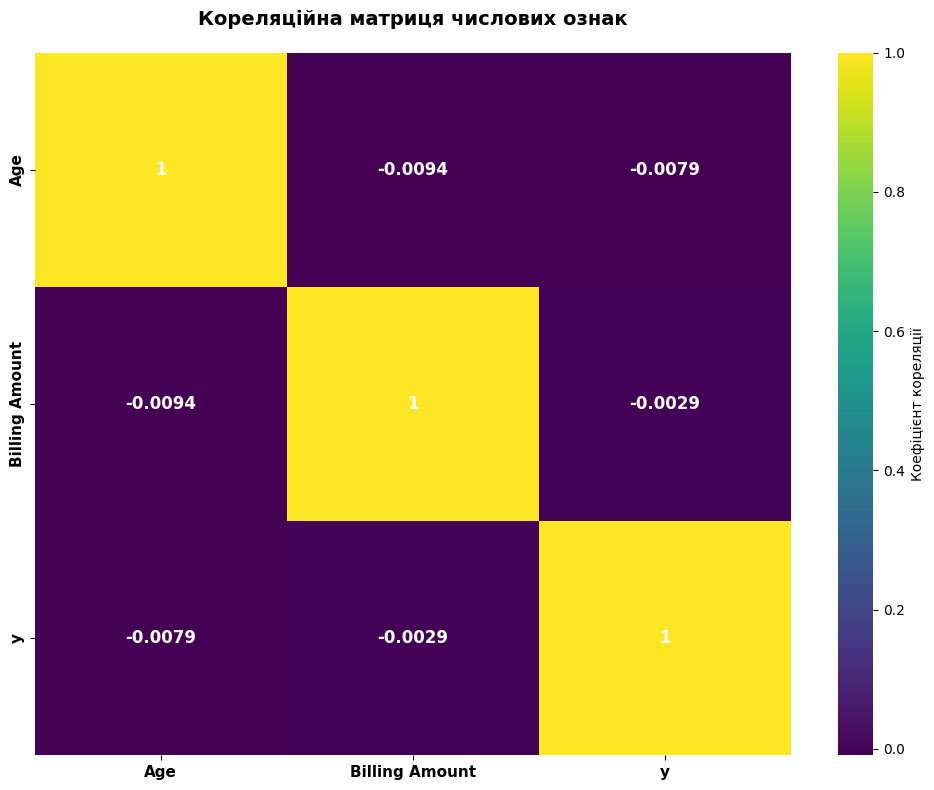

In [10]:
numeric_cols = ['Age', 'Billing Amount']
corr_matrix = df_bin[numeric_cols + ['y']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', 
            annot_kws={'size': 12, 'weight': 'bold', 'color': 'white'},
            cbar_kws={'label': 'Коефіцієнт кореляції'})
plt.title('Кореляційна матриця числових ознак', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

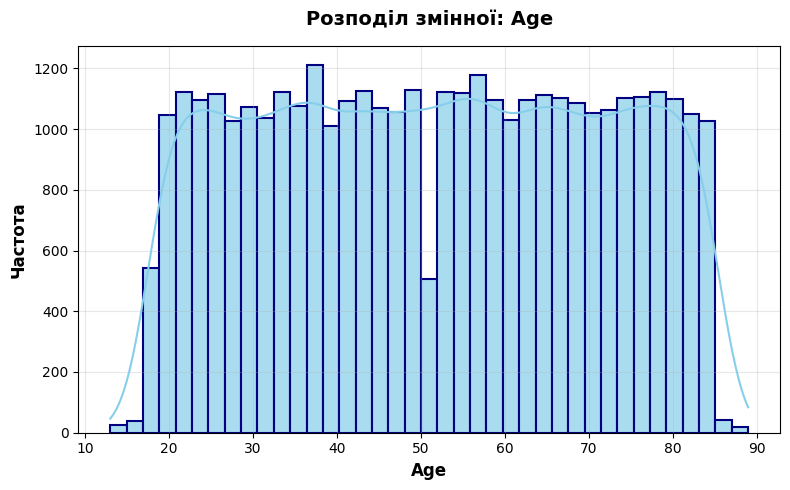

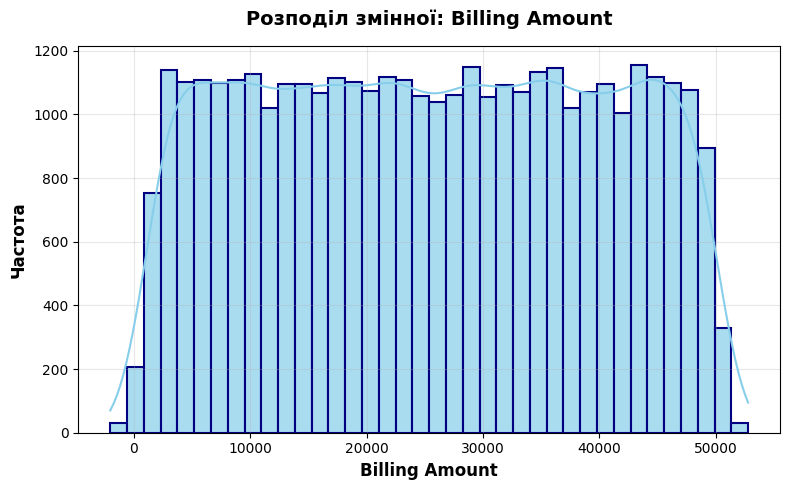

In [11]:
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_bin[col], kde=True, color='skyblue', 
                 edgecolor='navy', linewidth=1.5, alpha=0.7)
    plt.title(f'Розподіл змінної: {col}', fontsize=14, fontweight='bold', pad=15)
    plt.xlabel(col, fontsize=12, fontweight='bold')
    plt.ylabel('Частота', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

розділив дані на тренувальну (60%), валідаційну (20%) та тестову (20%) вибірки для коректної оцінки якості моделі.

In [12]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

NameError: name 'train_test_split' is not defined

Стандартизую числові ознаки, перетворюючи їх на однаковий масштаб з середнім 0 та стандартним відхиленням 1 для покращення збіжності градієнтного спуску.

In [ ]:
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

додав стовпець одиниць до матриць ознак для включення вільного члена (intercept) у модель лінійної регресії.

In [ ]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_val = np.c_[np.ones(X_val.shape[0]), X_val]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

Сигмоїдна функція

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))


функція для обчислення логарифмічних втрат для логістичної регресії

In [ ]:
def compute_loss(X, y, w, lambda_=0):
    p = sigmoid(np.dot(X, w))
    m = len(y)
    log_loss = -np.mean(y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10))
    reg = (lambda_ / (2 * m)) * np.sum(w[1:]**2)  
    return log_loss + reg


функція для обчислення градієнта функції втрат для логістичної регресії, визначаючи напрямок найшвидшого зростання помилки для подальшого оновлення ваг моделі.

In [ ]:

def compute_gradient(X, y, w, lambda_=0):
    p = sigmoid(np.dot(X, w))
    m = len(y)
    grad = np.dot(X.T, (p - y)) / m
    grad[1:] += (lambda_ / m) * w[1:]  
    return grad


In [ ]:
# Ініціалізація ваг
def initialize_weights(n_features):
    return np.zeros(n_features)

# Оновлення ваг
def update_weights(weights, gradients, learning_rate):
    return weights - learning_rate * gradients

функція,яка генерує випадкові міні-батчі даних для ефективного навчання моделі, перемішуючи спостереження та розбиваючи їх на невеликі партії.

In [ ]:
def get_batches(X, y, batch_size):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    for start in range(0, len(y), batch_size):
        end = min(start + batch_size, len(y))
        yield X[indices[start:end]], y[indices[start:end]]

Функція для навчання моделі логістичної регресії за допомогою градієнтного спуску з ранньою зупинкою, автоматично вибираючи найкращі ваги на основі валідаційних втрат.

In [ ]:
def train_logistic(X_train, y_train, X_val, y_val, learning_rate=0.1, max_epochs=50, batch_size=32, lambda_=0.01, patience=5):
    n_features = X_train.shape[1]
    w = np.zeros(n_features)
    best_val_loss = float('inf')
    best_epoch = 0
    best_w = None
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        if batch_size == 1:  # SGD
            for i in range(len(y_train)):
                grad = compute_gradient(X_train[i:i+1], y_train[i:i+1], w, lambda_)
                w -= learning_rate * grad
        else:  # Mini-batch
            for batch_X, batch_y in get_batches(X_train, y_train, batch_size):
                grad = compute_gradient(batch_X, batch_y, w, lambda_)
                w -= learning_rate * grad
        
        train_loss = compute_loss(X_train, y_train, w, lambda_)
        val_loss = compute_loss(X_val, y_val, w, lambda_)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_w = w.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_w, train_losses, val_losses

навчання логістичної регресії з використанням Стохастичного градієнтного спуску (SGD): 

In [ ]:
w_sgd, train_losses_sgd, val_losses_sgd = train_logistic(X_train, y_train, X_val, y_val, batch_size=1, lambda_=0.01)


Early stopping at epoch 6


навчання логістичної регресії з використанням Mini-batch градієнтного спуску:

In [ ]:
w_mini, train_losses_mini, val_losses_mini = train_logistic(X_train, y_train, X_val, y_val, batch_size=32, lambda_=0.01)

Early stopping at epoch 17


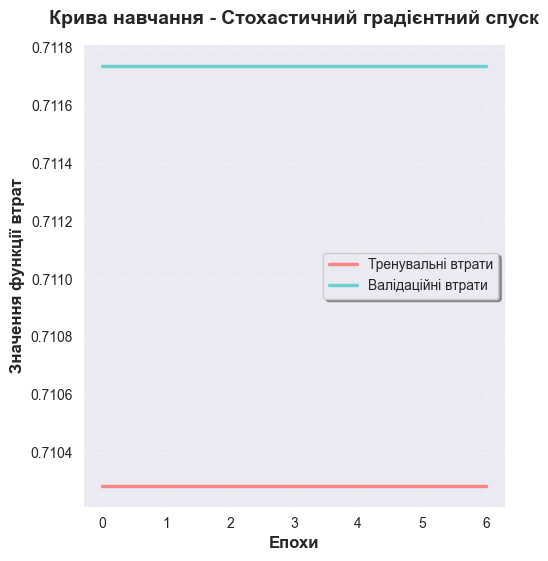

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='Тренувальні втрати', linewidth=2.5, color='#FF6B6B', alpha=0.8)
plt.plot(val_losses_sgd, label='Валідаційні втрати', linewidth=2.5, color='#4ECDC4', alpha=0.8)
plt.title('Крива навчання - Стохастичний градієнтний спуск', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Епохи', fontsize=12, fontweight='bold')
plt.ylabel('Значення функції втрат', fontsize=12, fontweight='bold')
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Крива навчання

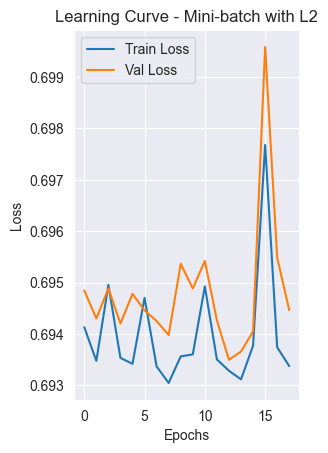

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_losses_mini, label='Train Loss')
plt.plot(val_losses_mini, label='Val Loss')
plt.title('Learning Curve - Mini-batch with L2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

 функція,яка оцінює якість моделі логістичної регресії на тестових даних, обчислюючи матрицю плутанини та основні метрики класифікації для аналізу ефективності прогнозування.

In [ ]:
def evaluate(w, X_test, y_test):
    y_pred_prob = sigmoid(np.dot(X_test, w))
    y_pred = (y_pred_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return cm, acc, prec, rec, f1

In [ ]:
cm_sgd, acc_sgd, prec_sgd, rec_sgd, f1_sgd = evaluate(w_sgd, X_test, y_test)
cm_mini, acc_mini, prec_mini, rec_mini, f1_mini = evaluate(w_mini, X_test, y_test)

confusion matrix

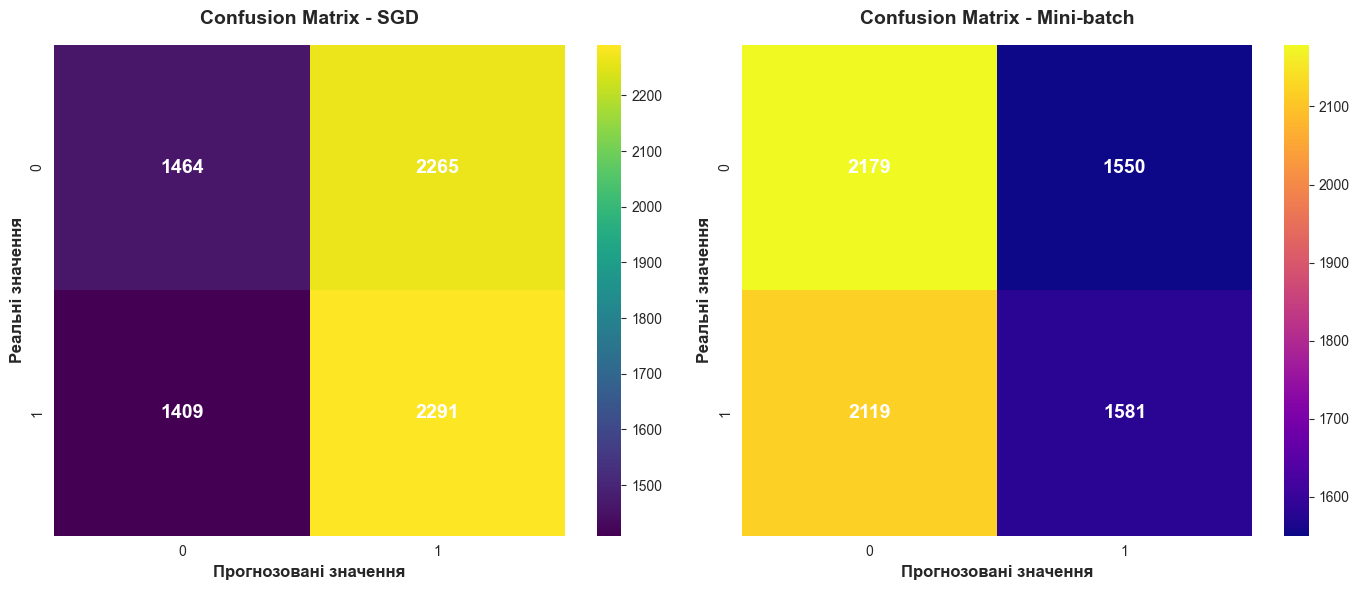

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='viridis', 
            annot_kws={'size': 14, 'weight': 'bold', 'color': 'white'})
plt.title('Confusion Matrix - SGD', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Прогнозовані значення', fontsize=12, fontweight='bold')
plt.ylabel('Реальні значення', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
sns.heatmap(cm_mini, annot=True, fmt='d', cmap='plasma', 
            annot_kws={'size': 14, 'weight': 'bold', 'color': 'white'})
plt.title('Confusion Matrix - Mini-batch', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Прогнозовані значення', fontsize=12, fontweight='bold')
plt.ylabel('Реальні значення', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

 метрики: Accuracy, Precision, Recall, F1-score.

In [ ]:
metrics_df = pd.DataFrame({
    'Method': ['SGD', 'Mini-batch L2'],
    'Accuracy': [acc_sgd, acc_mini],
    'Precision': [prec_sgd, prec_mini],
    'Recall': [rec_sgd, rec_mini],
    'F1-score': [f1_sgd, f1_mini]
})
print(metrics_df)

          Method  Accuracy  Precision    Recall  F1-score
0            SGD  0.505452   0.502853  0.619189   0.55499
1  Mini-batch L2  0.506125   0.504950  0.427297   0.46289
